In [1]:
import pandas as pd
from fbprophet import Prophet
from datetime import datetime

In [2]:
# Lendo os Dados
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
path = '/content/drive/MyDrive/data/'
dados_rodovias_2020 = pd.read_csv(path+'datatran2020.csv', encoding='cp1252', sep=';', parse_dates=['data_inversa'],
                           index_col='data_inversa', date_parser=dateparse)
dados_rodovias_2019 = pd.read_csv(path+'datatran2019.csv', encoding='cp1252', sep=';', parse_dates=['data_inversa'],
                           index_col='data_inversa', date_parser=dateparse)
dados_rodovias_2018 = pd.read_csv(path+'datatran2018.csv', encoding='cp1252', sep=';', parse_dates=['data_inversa'],
                           index_col='data_inversa', date_parser=dateparse)
dados_rodovias_2017 = pd.read_csv(path+'datatran2017.csv', encoding='cp1252', sep=';', parse_dates=['data_inversa'],
                           index_col='data_inversa', date_parser=dateparse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [3]:
# Concatenando
dados_rodovias_17_20 = pd.concat([dados_rodovias_2017,
                                  dados_rodovias_2018,
                                  dados_rodovias_2019,
                                  dados_rodovias_2020]).
                                  sort_values(by='data_inversa')
dados_rodovias_17_20['Ocorrencias'] = dados_rodovias_17_20['Ocorrencias']=1

In [76]:
time_series_ano = dados_rodovias_17_20.resample('A').sum()
time_series_ano = time_series_ano[['pessoas','mortos','veiculos','feridos','Ocorrencias']]
time_series_ano.tail(4)

,pessoas,mortos,veiculos,feridos,Ocorrencias
data_inversa,,,,,
2017-12-31,204395,6247,144987,84317,89563
2018-12-31,164802,5271,114473,76647,69295
2019-12-31,162273,5333,112051,79073,67446
2020-12-31,104383,3677,73807,50479,45368


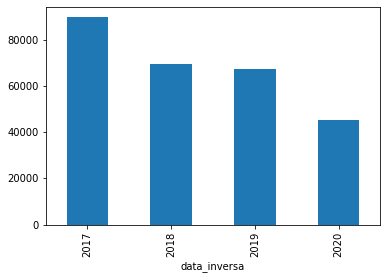

In [77]:
time_series_ano = dados_rodovias_17_20.groupby(dados_rodovias_17_20.index.to_period('y')).sum()
time_series_ano['Ocorrencias'].plot(kind='bar')

In [78]:
import plotly.express as px

fig = px.bar(time_series_ano,
             #x=time_series_ano.index,
             x=['2017','2018','2019','2020'],
             y='Ocorrencias',
             hover_data=['pessoas','veiculos'], 
             labels={'Ocorrencias':'Total de Ocorrências','x':'Ano'},
             height=400)

fig.show()

In [80]:
#time_series_day = dados_rodovias_17_20.groupby(dados_rodovias_17_20.index.to_period('d')).sum()
#time_series_day.tail()

In [22]:
# Aqui somamos o número de ocorrências por dia
time_series_dia = dados_rodovias_17_20.resample('D').sum().reset_index()

# Padronizando dados para Propeth
dataset_propeth = time_series_dia[['data_inversa',
                                   'Ocorrencias']].rename(columns={'data_inversa':'ds',
                                                                   'Ocorrencias':'y'})

In [55]:
# Feriados https://www.anbima.com.br/feriados/feriados.asp

path_h = '/content/drive/MyDrive/data/'
br_holidays = pd.read_excel(path+'feriados_nacionais.xls',
                         usecols=['Data','Feriado']
                        )

br_holidays = br_holidays.rename(columns={'Data':'ds',
                                          'Feriado':'holiday'})  
br_holidays.head(2)          

,ds,holiday
0,2001-01-01,Confraternização Universal
1,2001-02-26,Carnaval


In [81]:
mask = (br_holidays['ds'] >= '2017-01-01') & (br_holidays['ds'] <='2020-12-31')
br_holidays = (br_holidays.loc[mask])
br_holidays.head()  

,ds,holiday
192,2017-01-01,Confraternização Universal
193,2017-02-27,Carnaval
194,2017-02-28,Carnaval
195,2017-04-14,Paixão de Cristo
196,2017-04-21,Tiradentes


In [23]:
#model = Prophet(holidays=br_holidays)
# Criando o Modelo
model_prophet = Prophet()
model_prophet.fit(dataset_propeth)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
# Fazendo o Treinamento e Previsão até o fim do ano
future_2020 = model_prophet.make_future_dataframe(periods=92)
forecast_prophet = model_prophet.predict(future_2020)

In [35]:
forecast_prophet.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [71]:
forecast_prophet['yhat'].tail(7)

1454    215.744197
1455    228.831849
1456    223.310374
1457    179.378706
1458    158.810462
1459    158.777225
1460    163.081055
Name: yhat, dtype: float64

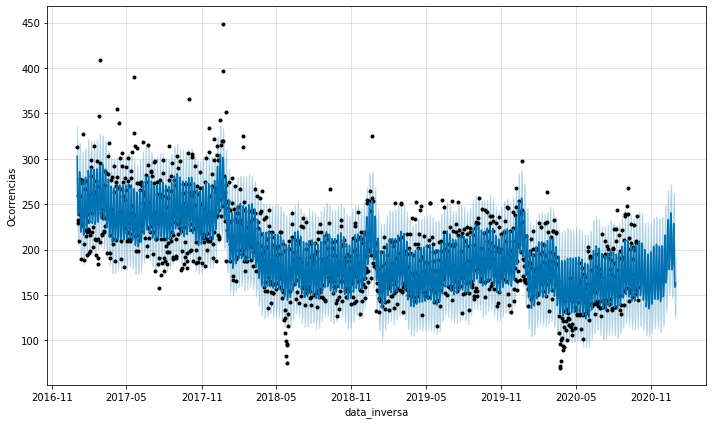

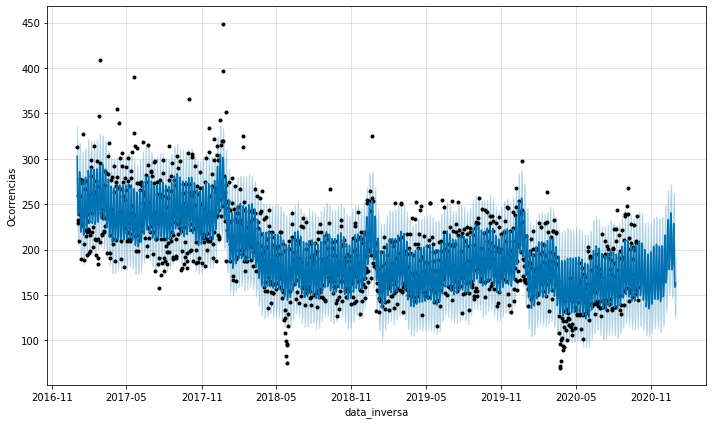

In [82]:
# Os pontos pretos são os dados reais e o que esta em azul são as previsões do algoritimo
#Fim da previsão mostra uma margem de erro do algoritimo
model_prophet.plot(forecast_prophet, 
           xlabel='data_inversa',
           ylabel='Ocorrencias')

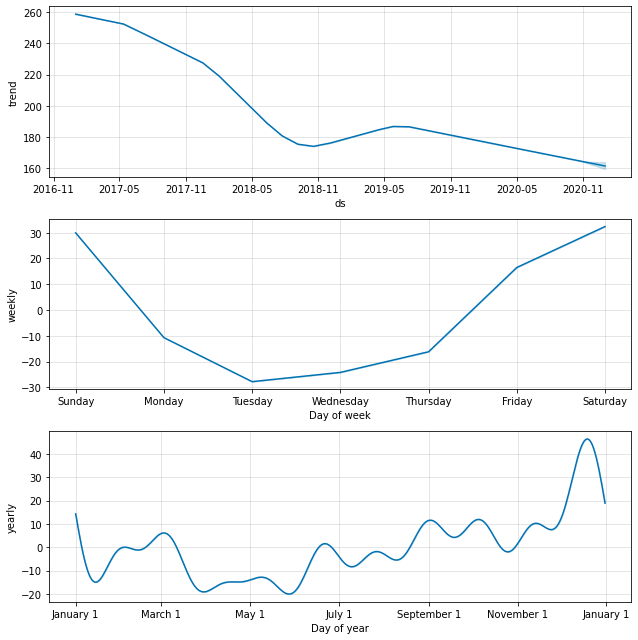

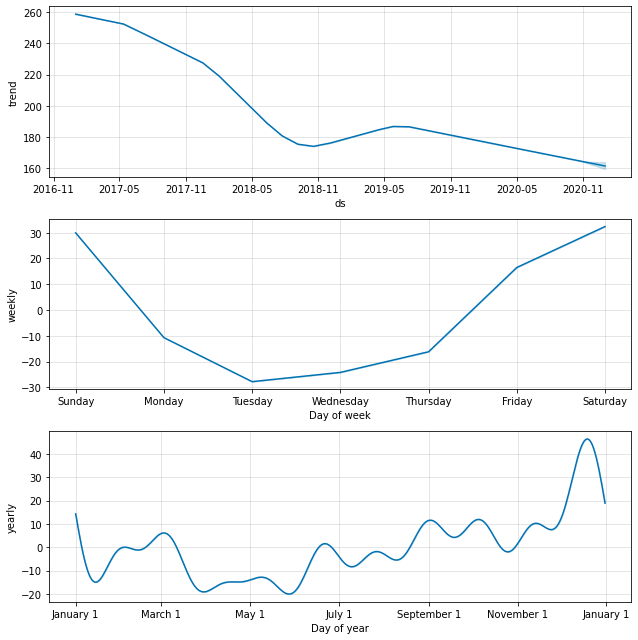

In [30]:
model_prophet.plot_components(forecast_prophet)

In [31]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_prophet, forecast_prophet)

In [40]:
plot_components_plotly(model_prophet, forecast_prophet)

In [69]:
# Feriados******
# Criando o Modelo
model_prophet_holiday = Prophet(holidays=br_holidays)
model_prophet_holiday.fit(dataset_propeth)
# Fazendo o Treinamento e Previsão até o dia 2 de Janeiro de 2021
future_2020 = model_prophet_holiday.make_future_dataframe(periods=94)
forecast_prophet_holiday = model_prophet_holiday.predict(future_2020)
forecast_prophet_holiday['yhat'].tail(9)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1454    215.648042
1455    227.104896
1456    221.409288
1457    177.360787
1458    156.748084
1459    156.701195
1460    160.984161
1461    190.680202
1462    202.336476
Name: yhat, dtype: float64

In [65]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_prophet_holiday, forecast_prophet_holiday)

In [66]:
plot_components_plotly(model_prophet_holiday,
                       forecast_prophet_holiday)